In [1]:
from datasets import *
from train import *
from torchvision import datasets, transforms, models
from matplotlib.pyplot import figure
from tqdm import tqdm

In [2]:
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
# model64 = models.mobilenet_v3_large()
# model64.load_state_dict(torch.load("best_modelsv3/best_batch_i1081020.pth")['model_state_dict'])
model128 = models.mobilenet_v3_small()
model128.classifier[0] = torch.nn.Linear(576,1280)
model128.classifier[3] = torch.nn.Linear(1280,1000)
model128.load_state_dict(torch.load("best_batch_i162153.pth")['model_state_dict'])
# model128 = models.mobilenet_v3_small()
# model128.classifier[0] = torch.nn.Linear(576,1280)
# model128.classifier[3] = torch.nn.Linear(1280,1000)
# model128.load_state_dict(torch.load("mnv3s/best_batch_i342323v3_small_frozen_head1676029877.1912067.pth")['model_state_dict'])
model128.to('cuda')
model.eval()
model128.eval()

activationT = {}
activationS = {}
def get_activationT(name):
    def hook(model, input, output):
        activationT[name] = output.detach()
    return hook
def get_activationS(name):
    def hook(model, input, output):
        activationS[name] = output.detach()
    return hook

model.classifier[0].register_forward_hook(get_activationT('emb'))
model128.classifier[0].register_forward_hook(get_activationS('emb'))
corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']

In [3]:
clean_embds,clean_labels,clean_preds = torch.load("embds/clean224.pt")
clean_embds128,clean_labels128,clean_preds128 = torch.load("embds/clean128.pt")
corr_embds = []
corr_labels = []
corr_preds = []
corr_embds128 = []
corr_labels128 = []
corr_preds128 = []
corr_embds64 = []
corr_labels64 = []
corr_preds64 = []
for i,corr in enumerate(corruptions):
    e,l,p = torch.load("embds/corr224_"+corr+".pt")
    e128,l128,p128 = torch.load("embds/corr128_"+corr+".pt")
    # e64,l64,p64 = torch.load("embds/corr64_"+corr+".pt")
    corr_embds.append(e)
    corr_labels.append(l)
    corr_preds.append(p)
    corr_embds128.append(e128)
    corr_labels128.append(l128)
    corr_preds128.append(p128)
    # corr_embds64.append(e64)
    # corr_labels64.append(l64)
    # corr_preds64.append(p64)

clean_results128 = (torch.argmax(clean_preds128,dim=1) == clean_labels)
clean_results = (torch.argmax(clean_preds,dim=1) == clean_labels)

class FC(torch.nn.Module):
    def __init__(self,feats):
      super(FC, self).__init__()
      self.c = torch.nn.Linear(feats,1000)
    def forward(self,x):
      return self.c(x)
fcs = FC(1280).eval()
fct = FC(1280).eval()
with torch.no_grad():
  fcs.c.weight[:,:] = model128.classifier[3].weight[:,:]
  fcs.c.bias[:] = model128.classifier[3].bias[:]
  fct.c.weight[:,:] = model.classifier[3].weight[:,:]
  fct.c.bias[:] = model.classifier[3].bias[:]

In [72]:
'''
methods should follow a modular structure by inheriting from
the abstract base class 'Policy'.
'''

from abc import ABC, abstractmethod
CHOOSE_STUDENT = 0
CHOOSE_TEACHER = 1 # assumes executed student first
CHOOSE_TEACHER_ONLY = 2 # assumes picked teacher without executing student
STUDENT_TEACHER_KD_HEAD = 3 # assumes execute both student and teacher and backprop through student head
STUDENT_TEACHER_KD_FULL = 4 # assumes execute both student and teacher and backprop through entire student

class Policy(ABC):
    # provide the student cost, teacher cost, and budget for the internal parameters
    # calling this repeatedlyshould reset the internal parameters
    @abstractmethod
    def initialize(self,student_cost: int, teacher_cost: int, budget: int):
        pass

    # execute the policy by giving it the next sample (student embedding tensor)
    # the policy returns a bool: 0 for student, 1 for teacher/label
    @abstractmethod
    def execute(self, next_sample: torch.Tensor, idx: int) -> int:
        pass

    # name of the policy
    @abstractmethod
    def __str__(self):
        pass


class EvalPolicy():
    # takes in a list of policies (type Policy)
    def __init__(self,policies: list, input_samples: torch.Tensor, student_results: torch.Tensor, \
                teacher_results: torch.Tensor, student_cost: int, teacher_cost: int, budgets: torch.Tensor) -> None:
        # input parameters
        self.policies = policies
        self.input_samples = input_samples
        self.student_results = student_results
        self.teacher_results = teacher_results
        self.student_cost = student_cost
        self.teacher_cost = teacher_cost
        self.budgets = budgets
        self.rand_idxs = torch.randperm(len(input_samples))

        # additional variables
        self.decisions = torch.zeros((len(policies),len(budgets),len(input_samples)))
        self.costs = torch.zeros((len(policies),len(budgets),len(input_samples)))
        self.results = torch.zeros((len(policies),len(budgets),len(input_samples)))

        self.final_costs = torch.zeros((len(policies),len(budgets)))
        self.final_accuracies = torch.zeros((len(policies),len(budgets)))
    
    def evaluate(self):
        print("# ===================== Starting Evaluation ===================== #")
        # evaluate each policy
        for policy_i,policy in enumerate(self.policies):
            print(f"Policy: {policy} ({policy_i+1}/{len(self.policies)})")
            for budget_i,budget in enumerate(self.budgets):
                policy.initialize(self.student_cost,self.teacher_cost,budget)
                print(f"Budget: {budget} ({budget_i+1}/{len(self.budgets)})")
                # for each policy go through evaluation process
                for sample_i,sample in enumerate(tqdm(self.input_samples)):
                    # get the policy decision
                    decision = policy.execute(self.input_samples[self.rand_idxs[sample_i]],self.rand_idxs[sample_i])
                    self.decisions[policy_i,budget_i,sample_i] = (decision > 0)

                    # update the policy cost
                    if decision == CHOOSE_STUDENT:
                        self.costs[policy_i,budget_i,sample_i] += self.student_cost
                    elif decision == CHOOSE_TEACHER:
                        self.costs[policy_i,budget_i,sample_i] += self.student_cost + self.teacher_cost
                    elif decision == CHOOSE_TEACHER_ONLY:
                        self.costs[policy_i,budget_i,sample_i] += self.teacher_cost
                    elif decision == STUDENT_TEACHER_KD_HEAD:
                        self.costs[policy_i,budget_i,sample_i] += self.teacher_cost + 1.1*self.student_cost

                    # check that the policy stays in budget
                    assert torch.sum(self.costs[policy_i,budget_i,:sample_i+1])/(sample_i+1) <= budget+0.01, \
                        f"Policy {policy} has average cost {sum(self.costs[policy_i,budget_i,:sample_i+1])/(sample_i+1)} which exceeds budget {budget}."
                    self.results[policy_i,budget_i,sample_i] = self.student_results[self.rand_idxs[sample_i]] if (decision == CHOOSE_STUDENT) else self.teacher_results[self.rand_idxs[sample_i]]

                # after evaluating the policy, update its final cost and accuracy
                self.final_costs[policy_i,budget_i] = torch.sum(self.costs[policy_i,budget_i,:])/len(self.input_samples)
                self.final_accuracies[policy_i,budget_i] = torch.sum(self.results[policy_i,budget_i,:])/len(self.input_samples)

    def plot_results(self):
        fig, ax = plt.subplots()
        cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        legends = []
        handles_ = [[] for i in range(len(self.policies)+1)]
        for policy_i,policy in enumerate(self.policies):
            plt.plot(self.final_costs[policy_i,:],self.final_accuracies[policy_i,:],c=cycle[policy_i])
            for budget_i, budget in enumerate(self.budgets):
                if policy_i == 0:
                    handles_[policy_i].append(ax.axvline(budget,label="budget: "+str(budget),c='k',alpha=(budget_i+1)/(len(self.budgets)+1)))
                handles_[policy_i+1].append(ax.scatter(self.final_costs[policy_i,budget_i],self.final_accuracies[policy_i,budget_i],label=str(policy)+": "+str(budget),c=cycle[policy_i],alpha=(budget_i+1)/(len(self.budgets)+1),edgecolors='black'))
            legends.append(ax.legend(handles=handles_[policy_i+1],bbox_to_anchor=(1.3+0.45*(policy_i+1),1.05)))
        ax.legend(handles=handles_[0],bbox_to_anchor=(1.3,1.05))
        for policy_i,policy in enumerate(self.policies):
            ax.add_artist(legends[policy_i])
        plt.title("Cost vs Accuracy")
        plt.xlabel("Cost MACs (M)")
        plt.ylabel("Accuracy")
        


In [58]:
class RandomPolicy(Policy):
    def initialize(self,student_cost,teacher_cost, budget) -> None:
        # save policy variables
        self.student_cost = student_cost
        self.teacher_cost = teacher_cost
        self.budget = budget

        # set policy threshold based off of budget
        # p*student_cost + (1-p)*teacher_cost <= budget
        self.ps = (teacher_cost-budget)/(teacher_cost-student_cost)

        # keep track of avg cost internally so don't exceed budget
        self.total_cost = 0
        self.total_cost_counts = 0

    def execute(self, next_sample: torch.Tensor, idx: int) -> bool:
        # make decision randomly
        decision = torch.rand(1) > self.ps

        # update cost
        new_total_cost = (self.total_cost+self.student_cost) if (decision == 0) else (self.total_cost+self.teacher_cost)

        # if exceed threshold, then choose student
        if new_total_cost/(self.total_cost_counts+1) > self.budget:
            self.total_cost += self.student_cost
            self.total_cost_counts += 1
            return CHOOSE_STUDENT
        
        self.total_cost = new_total_cost
        self.total_cost_counts += 1

        if decision == 0:
            return CHOOSE_STUDENT
        else:
            return CHOOSE_TEACHER_ONLY

    def __str__(self):
        return "Random Policy"

In [59]:
class ConfidencePolicy(Policy):
    def __init__(self,model) -> None:
        self.model = model.eval().to('cuda')

    def initialize(self,student_cost,teacher_cost, budget) -> None:
        # save policy variables
        self.student_cost = student_cost
        self.teacher_cost = teacher_cost
        self.budget = budget

        # set policy threshold based off of budget
        # p*student_cost + (1-p)*(teacher_cost+student_cost) <= budget
        self.ps = (student_cost+teacher_cost-budget)/(teacher_cost)

        # keep track of confidence distribution
        self.n_bins = 30
        self.bin_boundaries = torch.linspace(0, 1, self.n_bins+1)
        self.bin_lowers = self.bin_boundaries[:-1]
        self.bin_uppers = self.bin_boundaries[1:]
        self.bin_marks = torch.cat([self.bin_lowers,self.bin_uppers[-1].unsqueeze(0)])
        self.conf_bins = torch.zeros(self.n_bins)
        self.conf_counts = 0

        # keep track of avg cost internall so don't exceed budget
        self.total_cost = 0
        self.total_cost_counts = 0

    def execute(self, next_sample: torch.Tensor, idx: int) -> bool:
        with torch.no_grad():
            conf = torch.max(torch.nn.functional.softmax(self.model(next_sample.unsqueeze(0).to('cuda')).cpu().view(-1),dim=0))
        # update confidence distribution
        bin = torch.logical_and(conf > self.bin_lowers,conf <= self.bin_uppers).nonzero()
        self.conf_bins *= self.conf_counts
        self.conf_bins[bin] += 1
        self.conf_counts += 1
        self.conf_bins /= self.conf_counts

        # get the ccdf to get the threshold
        conf_ccdf = torch.tensor([sum(self.conf_bins[len(self.conf_bins)-i:len(self.conf_bins)]) for i in range(len(self.conf_bins)+1)])
        conf_ccdf[-1] = 1.0
        bin_thresh = self.n_bins - (conf_ccdf >= self.ps).nonzero().view(-1).min()
        threshold = self.bin_marks[bin_thresh]

        # make selection
        if conf >= threshold:
            self.total_cost += self.student_cost
            self.total_cost_counts += 1
            return CHOOSE_STUDENT
        else:
            # update cost
            new_total_cost = (self.total_cost+self.student_cost+self.teacher_cost)

            # if exceed threshold, then choose student
            if new_total_cost/(self.total_cost_counts+1) > self.budget:
                self.total_cost += self.student_cost
                self.total_cost_counts += 1
                return CHOOSE_STUDENT

            self.total_cost = new_total_cost
            self.total_cost_counts += 1
            return CHOOSE_TEACHER

    def __str__(self):
        return "Confidence Policy"

In [60]:
class EntropyPolicy(Policy):
    def __init__(self,model) -> None:
        self.model = model.eval().to('cuda')

    def initialize(self,student_cost,teacher_cost, budget) -> None:
        # save policy variables
        self.student_cost = student_cost
        self.teacher_cost = teacher_cost
        self.budget = budget

        # set policy threshold based off of budget
        # p*student_cost + (1-p)*(teacher_cost+student_cost) <= budget
        self.ps = (student_cost+teacher_cost-budget)/(teacher_cost)

        # keep track of confidence distribution
        self.n_bins = 30
        self.bin_boundaries = torch.linspace(0, 1, 20+1)
        self.bin_boundaries = torch.cat([self.bin_boundaries[:-1],torch.linspace(1, 7, 10+1)])
        self.bin_lowers = self.bin_boundaries[:-1]
        self.bin_uppers = self.bin_boundaries[1:]
        self.bin_marks = torch.cat([self.bin_lowers,self.bin_uppers[-1].unsqueeze(0)])
        self.ent_bins = torch.zeros(self.n_bins)
        self.ent_counts = 0

        # keep track of avg cost internall so don't exceed budget
        self.total_cost = 0
        self.total_cost_counts = 0

    def execute(self, next_sample: torch.Tensor, idx: int) -> bool:
        with torch.no_grad():
            ent = torch.distributions.Categorical(
                    probs=(torch.nn.functional.softmax(self.model(next_sample.unsqueeze(0).to('cuda')).cpu().view(-1),dim=0))
                ).entropy()
        # update confidence distribution
        bin = torch.logical_and(ent > self.bin_lowers,ent <= self.bin_uppers).nonzero()
        self.ent_bins *= self.ent_counts
        self.ent_bins[bin] += 1
        self.ent_counts += 1
        self.ent_bins /= self.ent_counts

        # get the ccdf to get the threshold
        ent_cdf = torch.tensor([sum(self.ent_bins[:i+1]) for i in range(len(self.ent_bins)+1)])
        ent_cdf[-1] = 1.0
        bin_thresh = (ent_cdf >= self.ps).nonzero().view(-1).min() 
        threshold = self.bin_marks[bin_thresh]

        # make selection
        if ent <= threshold:
            self.total_cost += self.student_cost
            self.total_cost_counts += 1
            return CHOOSE_STUDENT
        else:
            # update cost
            new_total_cost = (self.total_cost+self.student_cost+self.teacher_cost)

            # if exceed threshold, then choose student
            if new_total_cost/(self.total_cost_counts+1) > self.budget:
                self.total_cost += self.student_cost
                self.total_cost_counts += 1
                return CHOOSE_STUDENT

            self.total_cost = new_total_cost
            self.total_cost_counts += 1
            return CHOOSE_TEACHER

    def __str__(self):
        return "Entropy Policy"

In [69]:
class KDHeadPolicy(Policy):
    def __init__(self,model,lr,grad_accum,temp) -> None:
        self.og_model = model
        self.lr = lr
        self.grad_accum = grad_accum
        self.temp = temp

    def initialize(self,student_cost,teacher_cost, budget) -> None:
        # for training
        self.model = copy.deepcopy(self.og_model).to('cuda')
        self.opt = torch.optim.SGD(params=self.model.parameters(),lr=self.lr)
        self.update_iter = 0

        # save policy variables
        self.student_cost = student_cost
        self.teacher_cost = teacher_cost
        self.budget = budget

        # set policy threshold based off of budget
        # p*student_cost + (1-p)*(teacher_cost+1.1*student_cost) <= budget
        #ps + t + 1.1s -pt -1.1ps <= b p(0.1s+t) >= t+1.1s-b
        self.ps = (1.1*student_cost+teacher_cost-budget)/(teacher_cost+0.1*student_cost)

        # keep track of confidence distribution
        self.n_bins = 30
        self.bin_boundaries = torch.linspace(0, 1, self.n_bins+1)
        self.bin_lowers = self.bin_boundaries[:-1]
        self.bin_uppers = self.bin_boundaries[1:]
        self.bin_marks = torch.cat([self.bin_lowers,self.bin_uppers[-1].unsqueeze(0)])
        self.conf_bins = torch.zeros(self.n_bins)
        self.conf_counts = 0

        # keep track of avg cost internall so don't exceed budget
        self.total_cost = 0
        self.total_cost_counts = 0

    def execute(self, next_sample: torch.Tensor, idx: int) -> bool:
        out = self.model(next_sample.unsqueeze(0).to('cuda'))
        with torch.no_grad():
            conf = torch.max(torch.nn.functional.softmax(out.cpu().view(-1),dim=0))

        # update confidence distribution
        bin = torch.logical_and(conf > self.bin_lowers,conf <= self.bin_uppers).nonzero()
        self.conf_bins *= self.conf_counts
        self.conf_bins[bin] += 1
        self.conf_counts += 1
        self.conf_bins /= self.conf_counts

        # get the ccdf to get the threshold
        conf_ccdf = torch.tensor([sum(self.conf_bins[len(self.conf_bins)-i:len(self.conf_bins)]) for i in range(len(self.conf_bins)+1)])
        conf_ccdf[-1] = 1.0
        bin_thresh = self.n_bins - (conf_ccdf >= self.ps).nonzero().view(-1).min()
        threshold = self.bin_marks[bin_thresh]

        # make selection
        if conf >= threshold:
            self.total_cost += self.student_cost
            self.total_cost_counts += 1
            return CHOOSE_STUDENT
        else:
            # update cost
            new_total_cost = (self.total_cost+1.1*self.student_cost+self.teacher_cost)

            # if exceed threshold, then choose student
            if new_total_cost/(self.total_cost_counts+1) > self.budget:
                self.total_cost += self.student_cost
                self.total_cost_counts += 1
                return CHOOSE_STUDENT

            self.total_cost = new_total_cost
            self.total_cost_counts += 1

            # update student model
            KD_loss = nn.KLDivLoss()(F.log_softmax(out/self.temp, dim=0),
                             F.softmax(corr_preds[0][idx].to('cuda')/self.temp, dim=0))
            KD_loss.backward()

            if ((self.update_iter + 1) % self.grad_accum) == 0:
                self.opt.step()
                self.opt.zero_grad()
                self.update_iter = 0
            else:
                self.update_iter += 1

            return STUDENT_TEACHER_KD_HEAD

    def __str__(self):
        return "KD Head Policy"

# ===================== Starting Evaluation ===================== #
Policy: Random Policy (1/4)
Budget: 1.0 (1/10)


100%|██████████| 50000/50000 [00:02<00:00, 19026.68it/s]


Budget: 2.0 (2/10)


100%|██████████| 50000/50000 [00:02<00:00, 18392.01it/s]


Budget: 3.0 (3/10)


100%|██████████| 50000/50000 [00:02<00:00, 19067.29it/s]


Budget: 4.0 (4/10)


100%|██████████| 50000/50000 [00:02<00:00, 18959.03it/s]


Budget: 5.0 (5/10)


100%|██████████| 50000/50000 [00:02<00:00, 18578.64it/s]


Budget: 6.0 (6/10)


100%|██████████| 50000/50000 [00:02<00:00, 18951.05it/s]


Budget: 7.0 (7/10)


100%|██████████| 50000/50000 [00:02<00:00, 18516.17it/s]


Budget: 8.0 (8/10)


100%|██████████| 50000/50000 [00:02<00:00, 18937.06it/s]


Budget: 9.0 (9/10)


100%|██████████| 50000/50000 [00:02<00:00, 18876.34it/s]


Budget: 10.0 (10/10)


100%|██████████| 50000/50000 [00:02<00:00, 18526.63it/s]


Policy: Confidence Policy (2/4)
Budget: 1.0 (1/10)


100%|██████████| 50000/50000 [00:55<00:00, 902.75it/s]


Budget: 2.0 (2/10)


100%|██████████| 50000/50000 [00:55<00:00, 901.78it/s]


Budget: 3.0 (3/10)


100%|██████████| 50000/50000 [00:55<00:00, 896.79it/s]


Budget: 4.0 (4/10)


100%|██████████| 50000/50000 [00:55<00:00, 901.32it/s]


Budget: 5.0 (5/10)


100%|██████████| 50000/50000 [00:55<00:00, 902.50it/s]


Budget: 6.0 (6/10)


100%|██████████| 50000/50000 [00:55<00:00, 899.00it/s]


Budget: 7.0 (7/10)


100%|██████████| 50000/50000 [00:55<00:00, 901.97it/s]


Budget: 8.0 (8/10)


100%|██████████| 50000/50000 [00:55<00:00, 898.90it/s]


Budget: 9.0 (9/10)


100%|██████████| 50000/50000 [00:55<00:00, 902.44it/s]


Budget: 10.0 (10/10)


100%|██████████| 50000/50000 [00:55<00:00, 898.76it/s]


Policy: Entropy Policy (3/4)
Budget: 1.0 (1/10)


100%|██████████| 50000/50000 [00:59<00:00, 838.76it/s]


Budget: 2.0 (2/10)


100%|██████████| 50000/50000 [00:59<00:00, 844.51it/s]


Budget: 3.0 (3/10)


100%|██████████| 50000/50000 [00:59<00:00, 839.09it/s]


Budget: 4.0 (4/10)


100%|██████████| 50000/50000 [00:59<00:00, 843.96it/s]


Budget: 5.0 (5/10)


100%|██████████| 50000/50000 [00:59<00:00, 842.67it/s]


Budget: 6.0 (6/10)


100%|██████████| 50000/50000 [00:59<00:00, 838.88it/s]


Budget: 7.0 (7/10)


100%|██████████| 50000/50000 [00:59<00:00, 841.40it/s]


Budget: 8.0 (8/10)


100%|██████████| 50000/50000 [00:59<00:00, 839.36it/s]


Budget: 9.0 (9/10)


100%|██████████| 50000/50000 [00:59<00:00, 840.46it/s]


Budget: 10.0 (10/10)


100%|██████████| 50000/50000 [00:59<00:00, 839.97it/s]


Policy: KD Head Policy (4/4)
Budget: 1.0 (1/10)


100%|██████████| 50000/50000 [00:56<00:00, 891.10it/s]


Budget: 2.0 (2/10)


  0%|          | 0/50000 [00:00<?, ?it/s]/home/gc28692/anaconda3/envs/cl/lib/python3.9/site-packages/torch/nn/functional.py:2916: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
100%|██████████| 50000/50000 [00:57<00:00, 864.47it/s]


Budget: 3.0 (3/10)


100%|██████████| 50000/50000 [00:59<00:00, 842.73it/s]


Budget: 4.0 (4/10)


100%|██████████| 50000/50000 [01:00<00:00, 820.82it/s]


Budget: 5.0 (5/10)


100%|██████████| 50000/50000 [01:02<00:00, 799.68it/s]


Budget: 6.0 (6/10)


100%|██████████| 50000/50000 [01:04<00:00, 777.38it/s]


Budget: 7.0 (7/10)


100%|██████████| 50000/50000 [01:05<00:00, 765.76it/s]


Budget: 8.0 (8/10)


100%|██████████| 50000/50000 [01:07<00:00, 741.69it/s]


Budget: 9.0 (9/10)


100%|██████████| 50000/50000 [01:08<00:00, 730.23it/s]


Budget: 10.0 (10/10)


100%|██████████| 50000/50000 [01:09<00:00, 718.42it/s]


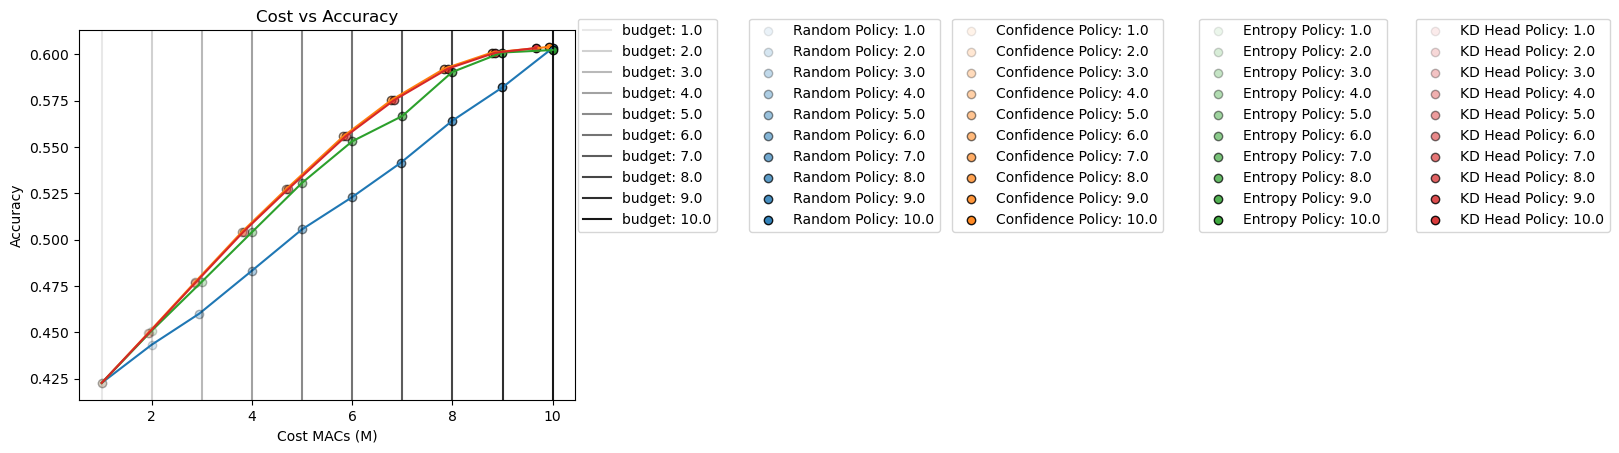

In [73]:
s_cost = 1
t_cost = 10
budgets = np.linspace(s_cost,t_cost,10)
policies = []
rp = RandomPolicy()
cp = ConfidencePolicy(fcs)
ep = EntropyPolicy(fcs)
kdh = KDHeadPolicy(fcs,0.001,16,3)
policies = [rp,cp,ep,kdh]

corr_results = torch.argmax(corr_preds[0],dim=1) == corr_labels[0]
corr_results128 = torch.argmax(corr_preds128[0],dim=1) == corr_labels[0]
Eval = EvalPolicy(policies,corr_embds128[0],corr_results128,corr_results,s_cost,t_cost,budgets)

Eval.evaluate()
Eval.plot_results()

In [47]:
correct_idxs = (torch.argmsax(corr_preds128[0],dim=1) == corr_labels[0]).nonzero()

In [130]:
same_count = 0
avg_nonzero = 0
avg_conf_bef = 0
avg_conf_aft = 0
for n in correct_idxs:
    emb = corr_embds128[0][n].view(-1).clone()
    with torch.no_grad():
        bef = fcs(emb)
        emb[emb <= 0] = 0
        aft = fcs(emb)
        if torch.argmax(bef) == torch.argmax(aft):
            same_count += 1
            avg_nonzero += torch.sum(emb>0)
            avg_conf_bef += torch.max(torch.nn.functional.softmax(bef,dim=0))
            avg_conf_aft += torch.max(torch.nn.functional.softmax(aft,dim=0))
    # print("GT:",corr_labels[0][n])
    # print("Before:",torch.argmax(bef))
    # print("After:",torch.argmax(aft))
    # print("Num nonzero:",torch.sum(aft>0))
print(same_count/len(correct_idxs))
print(avg_nonzero/same_count)
print(avg_conf_bef/same_count)
print(avg_conf_aft/same_count)

0.8742132412095973
tensor(513.1744)
tensor(0.7718)
tensor(0.6591)


: 

In [107]:
emb = corr_embds128[0][2].view(-1).clone()

In [108]:
emb

tensor([ 0.5353,  0.2107, -0.0568,  ...,  0.0420,  0.3845,  0.0412])

In [91]:
hist,edges = torch.histogram(emb,20)

In [92]:
edges

tensor([0.0000, 0.1876, 0.3752, 0.5628, 0.7504, 0.9380, 1.1256, 1.3132, 1.5008,
        1.6884, 1.8760, 2.0636, 2.2512, 2.4388, 2.6264, 2.8140, 3.0016, 3.1891,
        3.3767, 3.5643, 3.7519])

<BarContainer object of 20 artists>

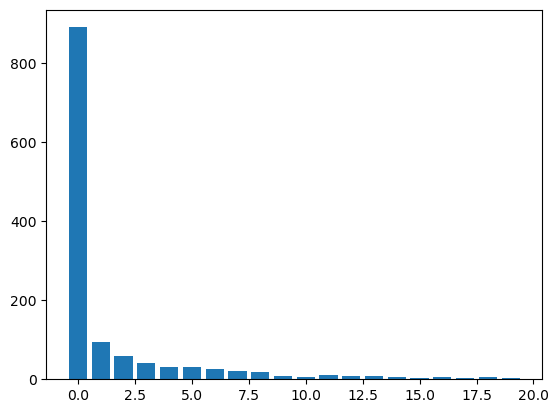

In [93]:
plt.bar(np.arange(len(hist)),hist)